In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=True) #n_workers=10, threads_per_worker=1, 
client = Client(cluster)  # memory_limit='16GB', 

import xarray as xr
from dask.diagnostics import ProgressBar

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [2]:
client

Client Scheduler: tcp://127.0.0.1:39914 Dashboard: http://127.0.0.1:40017/status,Cluster Workers: 8 Cores: 32 Memory: 203.20 GB


In [3]:
import sys
print(sys.executable)

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/bin/python3


In [4]:
def shift_time(ds, value):
    ds.coords['time'].values = pd.to_datetime(ds.coords['time'].values) + value
    return ds

In [5]:
static = xr.open_dataset('../data/danube/era5_slt_z_slor_lsm_stationary_field.nc')

In [6]:
era5 = xr.open_dataset('../data/danube/era5_danube_pressure_and_single_levels.nc')

In [7]:
glofas = xr.open_dataset('../data/danube/glofas_reanalysis_danube_1981-2002.nc')
glofas = glofas.rename({'lat': 'latitude', 'lon': 'longitude'})  # to have the same name like in era5
glofas = shift_time(glofas, -dt.timedelta(days=1))

In [8]:
glofas_rerun = xr.open_dataset('../data/glofas-freruns/2013051800/glofas2.3_era5wb_reforecast_dis_bigchannels_1000km2_20130518_0.nc')
glofas_rerun = glofas_rerun.rename({'lat': 'latitude', 'lon': 'longitude'})
glofas_rerun = shift_time(glofas_rerun, -dt.timedelta(days=1))

## feature selection

In [9]:
if not 'lsp' in era5:
    lsp = era5['tp']-era5['cp']
    lsp.name = 'lsp'
else:
    lsp = era5['lsp']

reltop = era5['z'].sel(level=500) - era5['z'].sel(level=850)
reltop.name = 'reltop'

q_mean = era5['q'].mean('level')
q_mean.name = 'q_mean'

era5 = xr.merge([era5['cp'], lsp, reltop, q_mean])

### Interpolation step

In [10]:
era5 = era5.interp(latitude=glofas.latitude, longitude=glofas.longitude)

### time subset

In [11]:
era5 = era5.isel(time=slice(0*365,3*365))
glofas = glofas.isel(time=slice(0*365,3*365))

if len(era5.time) < 3000:
    era5 = era5.load()
    glofas = glofas.load()

In [12]:
krems = dict(latitude=48.403, longitude=15.615)

surrounding = dict(latitude=slice(krems['latitude']+1, 
                                  krems['latitude']-1),
                   longitude=slice(krems['longitude']-1, 
                                  krems['longitude']+1))

In [13]:
# select data of interest
dis = glofas.interp(krems)
y = dis #.diff('time', 1)  # forecast time difference of discharge
X = era5.sel(surrounding).mean(['latitude', 'longitude'])
X

<xarray.Dataset>
Dimensions:  (time: 1095)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1983-12-31
Data variables:
    cp       (time) float64 0.001624 0.0008551 0.0008235 ... 0.0004743 6.423e-05
    lsp      (time) float64 0.000967 0.002493 0.0079 ... 0.0001274 0.001093
    reltop   (time) float64 3.924e+04 3.87e+04 4.008e+04 ... 4.065e+04 4.001e+04
    q_mean   (time) float64 0.001418 0.001336 0.002463 ... 0.001842 0.001696

In [14]:
def add_shifted_predictors(ds, shifts, variables='all'):
    """Adds additional variables to an array which are shifted in time.
    
    Parameters
    ----------
    ds : xr.Dataset
    shifts : list of integers
    variables : str or list
    """
    if variables == 'all': 
        variables = ds.data_vars
        
    for var in variables:
        for i in shifts:
            if i == 0: continue  # makes no sense to shift by zero
            newvar = var+'-'+str(i)
            ds[newvar] = ds[var].shift(time=i)
    return ds

In [15]:
shifts = range(1,11)
notshift_vars = ['swvl1', 'swvl2']
shift_vars = [v for v in X.data_vars if not v in notshift_vars]

Xs = add_shifted_predictors(X, shifts, variables=shift_vars)

In [16]:
Xar = Xs.to_array(dim='features')
yar = y.to_array()
yar = yar.rename({'variable': 'features'})
yar = yar.drop(['latitude', 'longitude'])

In [17]:
Xy = xr.concat([Xar, yar], dim='features')  
Xyt = Xy.dropna('time', how='any')  # drop them as we cannot train on nan values

In [18]:
Xy.shape

(45, 1095)

In [19]:
assert len(Xyt.time) > 1

In [20]:
predictand = 'dis'
predictors = [v for v in Xyt.coords['features'].values if v != predictand]

In [21]:
Xda = Xyt.loc[predictors]
yda = Xyt.loc[predictand]

In [22]:
predictors

['cp',
 'lsp',
 'reltop',
 'q_mean',
 'cp-1',
 'cp-2',
 'cp-3',
 'cp-4',
 'cp-5',
 'cp-6',
 'cp-7',
 'cp-8',
 'cp-9',
 'cp-10',
 'lsp-1',
 'lsp-2',
 'lsp-3',
 'lsp-4',
 'lsp-5',
 'lsp-6',
 'lsp-7',
 'lsp-8',
 'lsp-9',
 'lsp-10',
 'reltop-1',
 'reltop-2',
 'reltop-3',
 'reltop-4',
 'reltop-5',
 'reltop-6',
 'reltop-7',
 'reltop-8',
 'reltop-9',
 'reltop-10',
 'q_mean-1',
 'q_mean-2',
 'q_mean-3',
 'q_mean-4',
 'q_mean-5',
 'q_mean-6',
 'q_mean-7',
 'q_mean-8',
 'q_mean-9',
 'q_mean-10']

In [23]:
time = yda.time
Xda = Xda.chunk(dict(time=-1, features=-1)).data.T
yda = yda.data.squeeze()

In [24]:
Xda

dask.array<transpose, shape=(1085, 44), dtype=float64, chunksize=(1085, 44)>

In [25]:
yda

array([511.176361  , 508.53819285, 505.81103593, ..., 401.64623683,
       401.4437952 , 394.49342294])

In [26]:
import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

#from dask_ml.xgboost import XGBRegressor
from dask_ml.linear_model import LogisticRegression
from dask_ml.linear_model import LinearRegression


In [27]:
model_kws = dict(n_jobs=-1, max_iter=10000, verbose=True)

pipe = Pipeline([('scaler', StandardScaler()),
                 #('pca', PCA(n_components=6)),
                 ('model', LinearRegression(**model_kws)),],
                verbose=True)

In [28]:
pipe

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LinearRegression(C=1.0, class_weight=None, dual=False,
                                  fit_intercept=True, intercept_scaling=1.0,
                                  max_iter=10000, multi_class='ovr', n_jobs=-1,
                                  penalty='l2', random_state=None,
                                  solver='admm', solver_kwargs=None, tol=0.0001,
                                  verbose=True, warm_start=False))],
         verbose=True)

In [29]:
Xda = Xda.persist()

with ProgressBar():
    pipe.fit(Xda, yda)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.5s
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.1s


# Test it on the same data

In [30]:
def add_time(vector, time, name=None):
    """Converts arrays to xarrays with a time coordinate."""
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

In [39]:
with ProgressBar():
    ytest = pipe.predict(Xda)

In [40]:
ytest = add_time(ytest, time, name='dis-forecast')

Text(0, 0.5, 'river discharge [m$^3$/s]')

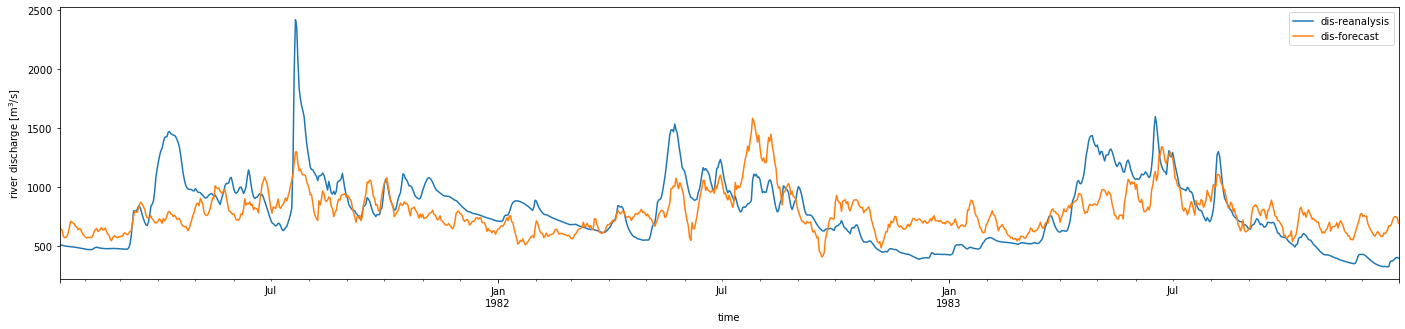

In [42]:
fig, ax = plt.subplots(figsize=(24,5))
Xyt.loc[predictand].to_pandas().plot(ax=ax, label='dis-reanalysis')
ytest.to_pandas().plot(ax=ax, label='dis-forecast')
plt.legend()
ax.set_ylabel('river discharge [m$^3$/s]')